In [8]:
import numpy as np  
import matplotlib.pyplot as plt  
import astropy.constants as c  
import astropy.units as u  

year  = (1*u.year).cgs.value
au    = c.au.cgs.value
M_jup = c.M_jup.cgs.value
M_sun = c.M_sun.cgs.value

from simple_slider import Widget
from simple_slider import kanagawa_profile
from simple_slider import get_surface_density
from simple_slider import get_disk_height

%matplotlib notebook

In [9]:
import simple_slider
import os

In [10]:
data_dir = simple_slider.pkg_resources.resource_filename(simple_slider.__name__, 'data_1_planet')
r = (np.loadtxt(os.path.join(data_dir, 'radius.dat')))
sigma = np.loadtxt(os.path.join(data_dir, 'sigma_averaged.dat'), unpack=1)
time = np.loadtxt(os.path.join(data_dir, 'time.dat'))

Get the data

In [11]:
t   = time.searchsorted(5 * 1e5 * year)
#t  = 0
sig = sigma[:, t]
print(len(r))

1024


Define the logp function: create a model based on the parameters and compare it to the data

In [12]:
def logp(params, x_data, y_data, n_planets):
    
    # convert parameter to physical values
    x_min = np.log10(x_data[0]/ au) 
    x_max = np.log10(x_data[-1]/ au) 
    
    # convert walkers from {0,1} to physical values for now    
    alpha = 10**(params[0]*3 -4)
    sig0  = 10**(4 * (params[1]-0.5))
    p     = (2.0 * params[2]) - 2
    R_p   = []
    mass_ratios = []
    for n in range(n_planets):
        R_p         += [10**(params[3 + 2 * n] * (x_max - x_min) + x_min) * au]
        mass_ratios += [10**(params[4 + 2 * n] * 2.0 - 4.0)]
        
    h_p = np.interp(R_p, x_data, get_disk_height(x_data))
    
    # construct the model
    sig_model = get_surface_density(x_data, alpha, sig0, p, R_p, h_p, mass_ratios)
    sigma2    = (0.05 * y_data)**2
    
    # calculate logP

    logP = -0.5 * np.sum((y_data[0:-1] - sig_model[0:-1]) ** 2 / sigma2[0:-1] + np.log(2 * np.pi * sigma2[0:-1]))
    
    return logP


Test if logP works

In [13]:
print(logp([0.5, 0.5, 0.5, 0.5, 0.5], r, sig, 1))
# should return a number

-97470.38508401762


Now optimize it 

In [14]:
def log_prior(params, n_planets):
    alpha = params[0]
    sig0  = params[1]
    p     = params[2]
    R_p   = []
    mass_ratios = []
    for n in range(n_planets):
        R_p         = params[3 + 2 * n]
        mass_ratios = params[4 + 2 * n]
    
    if 0 < alpha < 1 and 0 < sig0 < 1 and 0 < p < 1 and 0 < R_p < 1 and 0 < mass_ratios < 1: 
        return 0.0
    return -np.inf

In [15]:
def log_prob(params, x_data, y_data, n_planets):
    lp = log_prior(params, n_planets)
    if not np.isfinite(lp):
        return -np.inf
    return lp + logp(params, x_data, y_data, n_planets)

In [16]:
import emcee
#from multiprocessing import Pool

nwalkers = 500
# need to input ndim as 3 + (2 * n_plantes) somewhere else
ndim = 5

pos = np.random.rand(nwalkers, ndim)
nwalkers, ndim = pos.shape

#with Pool() as pool:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob,args=(r, sig, 1))
sampler.run_mcmc(pos, 1000, progress=True);

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:04<00:00, 92.24it/s]


In [17]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
#print(sampler.get_autocorr_time())

Mean acceptance fraction: 0.349


<IPython.core.display.Javascript object>


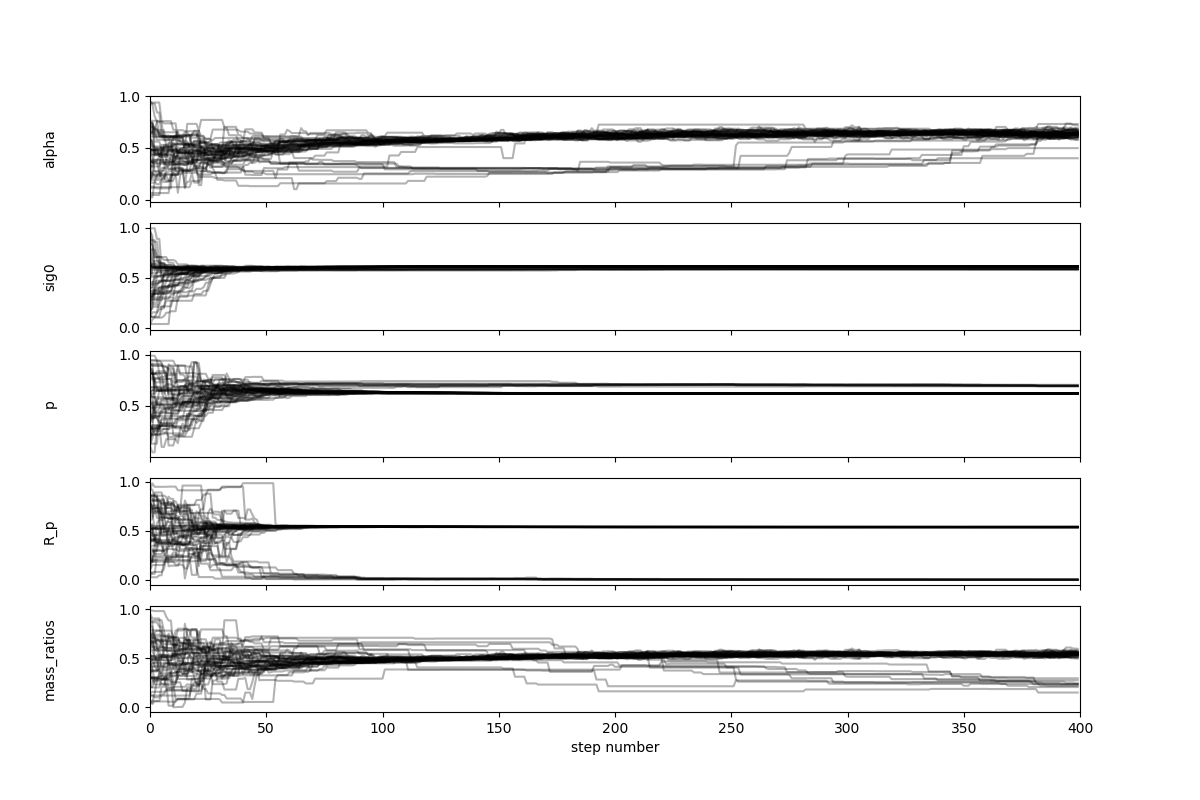

In [18]:
fig, axes = plt.subplots(ndim, figsize=(12, 8), sharex=True)
samples = sampler.get_chain()
labels = ["alpha", "sig0", "p", "R_p","mass_ratios", "R_p","mass_ratios", "R_p","mass_ratios"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [19]:
flat_samples = sampler.get_chain(discard=200, flat=True)
means = []
mcmc = []
for i in range(ndim):
    means += [np.mean(flat_samples[:,i])]
    mcmc += [np.percentile(flat_samples[:, i], 50)]
    
print("mean values: ", means)
print("50th percentiles: ", mcmc)

mean values:  [0.6007613363718125, 0.6055796920136626, 0.6376243439233361, 0.4409208225570966, 0.49944804038377916]
50th percentiles:  [0.6301223815029329, 0.6100103373776196, 0.6235867490523757, 0.5373707793849549, 0.535243184002838]


(10000, 5)


<IPython.core.display.Javascript object>


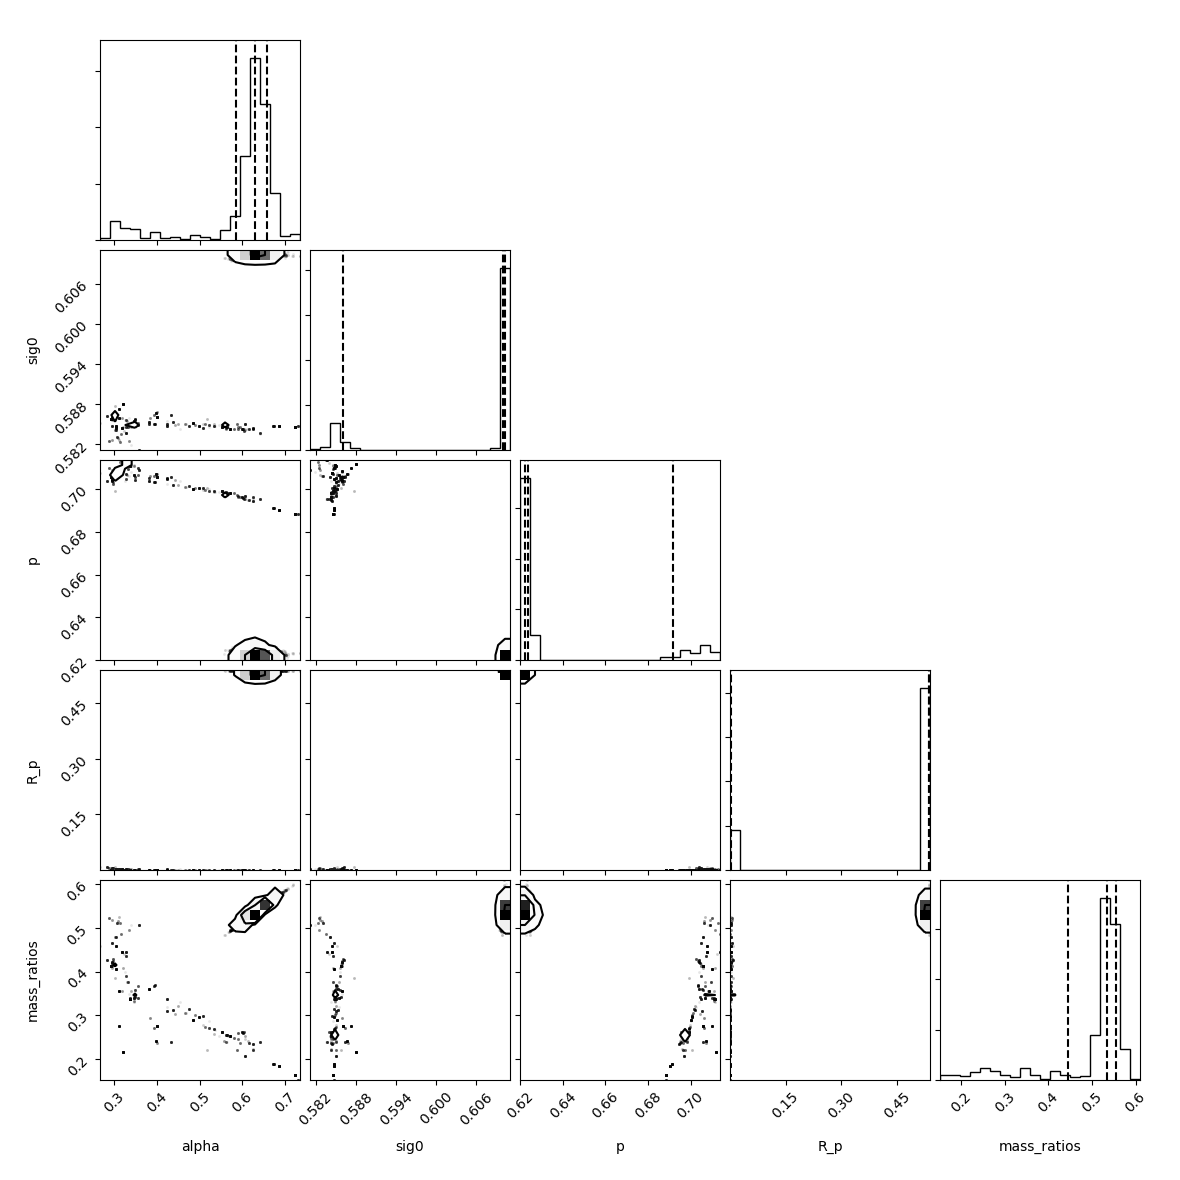

In [20]:
#labels = ["alpha", "sig0", "p", "R_p", "mass_ratios"]
print(flat_samples.shape)

import corner
fig = corner.corner(flat_samples, labels=labels, quantiles=[0.16, 0.5, 0.84]);

In [21]:
def conv_params_model(params, x_data, n_planets):
    
    x_min = np.log10(x_data[0]/ au) 
    x_max = np.log10(x_data[-1]/ au) 
    
    # convert walkers from {0,1} to physical values for now    
    alpha = 10**(params[0]*3 -4)
    sig0  = 10**(4 * (params[1]-0.5))
    p     = (2.0 * params[2]) - 2
    R_p   = []
    mass_ratios = []
    for n in range(n_planets):
        R_p         += [10**(params[3 + 3 * n] * (x_max - x_min) + x_min) * au]
        mass_ratios += [10**(params[4 + 3 * n] * 2.0 - 4.0)]
        
    h_p = np.interp(R_p, x_data, get_disk_height(x_data))
    
    return alpha, sig0, p, R_p, h_p, mass_ratios

<IPython.core.display.Javascript object>


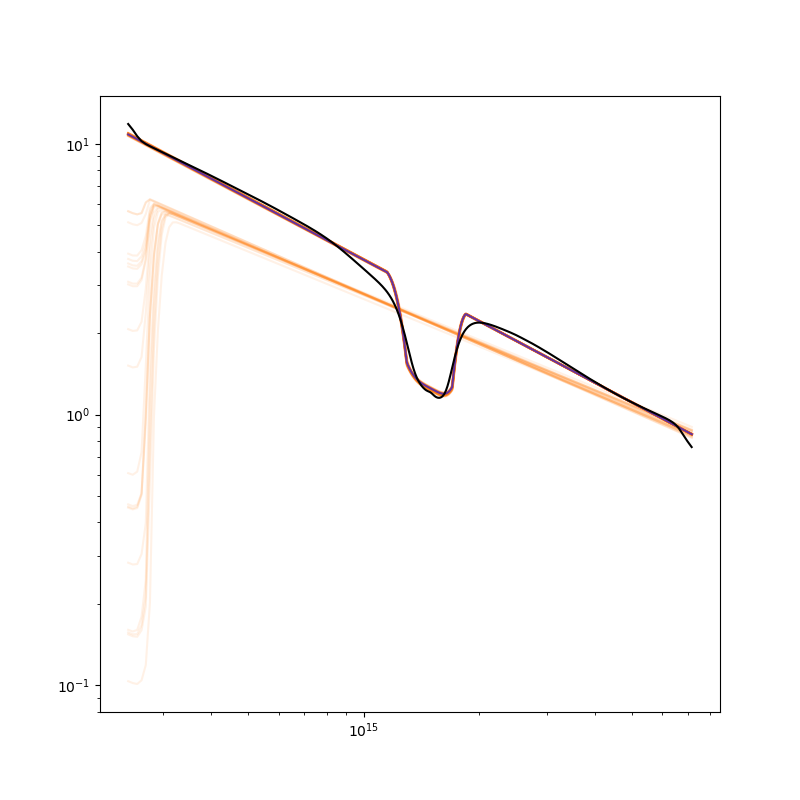

In [27]:
inds = np.random.randint(len(flat_samples), size=100)
f, ax2 = plt.subplots(figsize=(8, 8))
for ind in inds:
    sample = flat_samples[ind]
    a, s, p, rp, hp, m = conv_params_model(sample, r, 1)
    ax2.loglog(r, get_surface_density(r, a, s, p, rp, hp, m), "C1", alpha=0.1)
    
a, s, p, rp, hp, m = conv_params_model(mcmc, r, 1)
ax2.loglog(r, get_surface_density(r, a, s, p, rp, hp, m), "b", alpha=0.6)
ax2.loglog(r[0:-1], sig[0:-1], "k")

In [23]:
#print("50th percentiles: alpha: {:.3f}, Sigma: {:.2f}, p: {:.2f}, R_p: {:.3e}, h_p: {:.3e}, mass ratio: {:.2e}".format(a, s, p, rp, hp, m))
print("50th percentile, parameters in cgs units:")
for i in range(ndim):
    print(labels[i], " :", conv_params_model(mcmc, r, 1)[i])
    

50th percentile, parameters in cgs units:
alpha  : 0.007769036190178881
sig0  : 2.754490948047996
p  : -0.7528265018952487
R_p  : [1498035300810547.2]
mass_ratios  : [1.34794465e+14]
